## Setting Up

In [1]:
import json
import os
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision.models import resnet18
import torchvision.transforms as T
import torch.nn.functional as F

# reading lime_image
from lime import lime_image

from skimage.segmentation import mark_boundaries 

In [3]:
# Set random seed for reproducibility.
np.random.seed(0)
torch.manual_seed(0) 

device ="cuda:0" if torch.cuda.is_available() else "cpu"

In [8]:
# loading the model
resnet = resnet18(pretrained=True)
resnet = resnet.eval().to(device)

# reading imagenet classes
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.join("/kaggle/input/imagenet/","imagenet_class_index.json"), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [19]:
# Func to standardize image as an input for ResNet model
def pil_to_torch(img):
    transf = T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]) 
    ])        
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

# Func to convert an image to a tensor torch without normalizing for LIME
def pil_transform(img): 
    transf = T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop(224)
    ])    

    return transf(img)

# Func that gets images in the form of numpy arrays and make predictiosn using our ResNet model.
def cnn_predict(images): 
    transf = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
        ])
    
    batch = torch.stack(tuple(transf(img) for img in images), dim=0)

    logits = resnet(batch.to(device)).cpu()
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

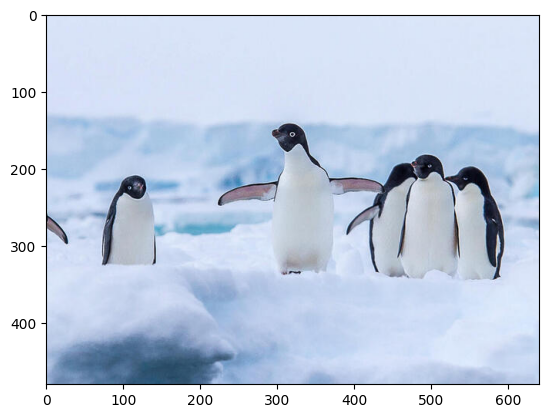

In [20]:
# Read the target image
img_pil_0 = Image.open(os.path.join("/kaggle/input/penguin/","penguin.jpg")).convert('RGB')

_ = plt.imshow(img_pil_0)

In [21]:
# ResNet prediction
img0 = pil_to_torch(img_pil_0)

logits = resnet(img0.to(device))
probs = F.softmax(logits, dim=1).cpu()
probs5 = probs.topk(10)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.86759007, 145, 'king_penguin'),
 (0.036420256, 99, 'goose'),
 (0.018590689, 81, 'ptarmigan'),
 (0.014464502, 267, 'standard_poodle'),
 (0.0074715544, 146, 'albatross'),
 (0.003918828, 795, 'ski'),
 (0.003027371, 537, 'dogsled'),
 (0.0029654503, 792, 'shovel'),
 (0.002754818, 80, 'black_grouse'),
 (0.0024293556, 97, 'drake'))

In [22]:
# Use LIME
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pil_transform(img_pil_0)), 
                                         cnn_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

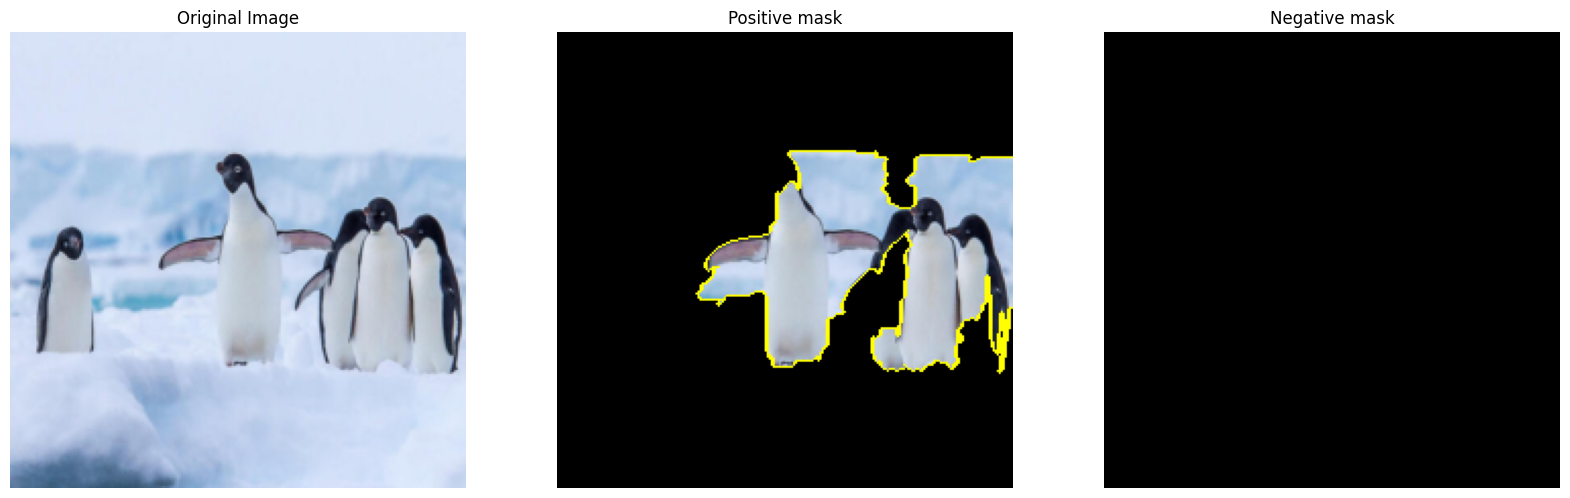

In [27]:
fig, axes = plt.subplots(1,3, figsize=(20, 10))

axes[0].imshow(pil_transform(img_pil_0))
axes[0].axis('off')
axes[0].set_title("Original Image")

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, negative_only=False, 
                                            num_features=5, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[1].imshow(img_boundry)
axes[1].set_title("Positive mask")
axes[1].axis('off')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, negative_only=True, 
                                            num_features=5, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[2].imshow(img_boundry)
axes[2].set_title("Negative mask")
axes[2].axis('off')

plt.show()

((0.3207359, 104, 'wallaby'),
 (0.14252238, 224, 'groenendael'),
 (0.04406644, 285, 'Egyptian_cat'),
 (0.036180872, 227, 'kelpie'),
 (0.028344309, 284, 'Siamese_cat'),
 (0.028189465, 273, 'dingo'),
 (0.023700586, 268, 'Mexican_hairless'),
 (0.021753173, 199, 'Scotch_terrier'),
 (0.0207983, 235, 'German_shepherd'),
 (0.020447448, 225, 'malinois'))

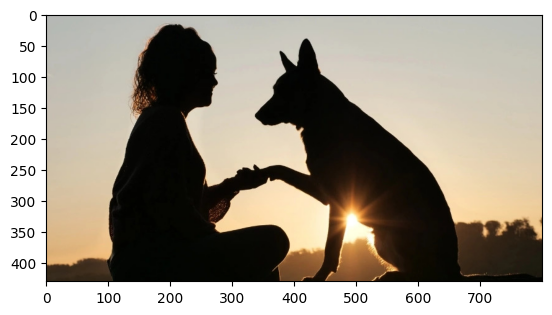

In [29]:
# Read the target image
img_pil_0 = Image.open(os.path.join("/kaggle/input/others/","The-human-AnimalBond_Content.jpg")).convert('RGB')

_ = plt.imshow(img_pil_0)

# ResNet prediction
img0 = pil_to_torch(img_pil_0)

logits = resnet(img0.to(device))
probs = F.softmax(logits, dim=1).cpu()
probs5 = probs.topk(10)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

  0%|          | 0/1000 [00:00<?, ?it/s]

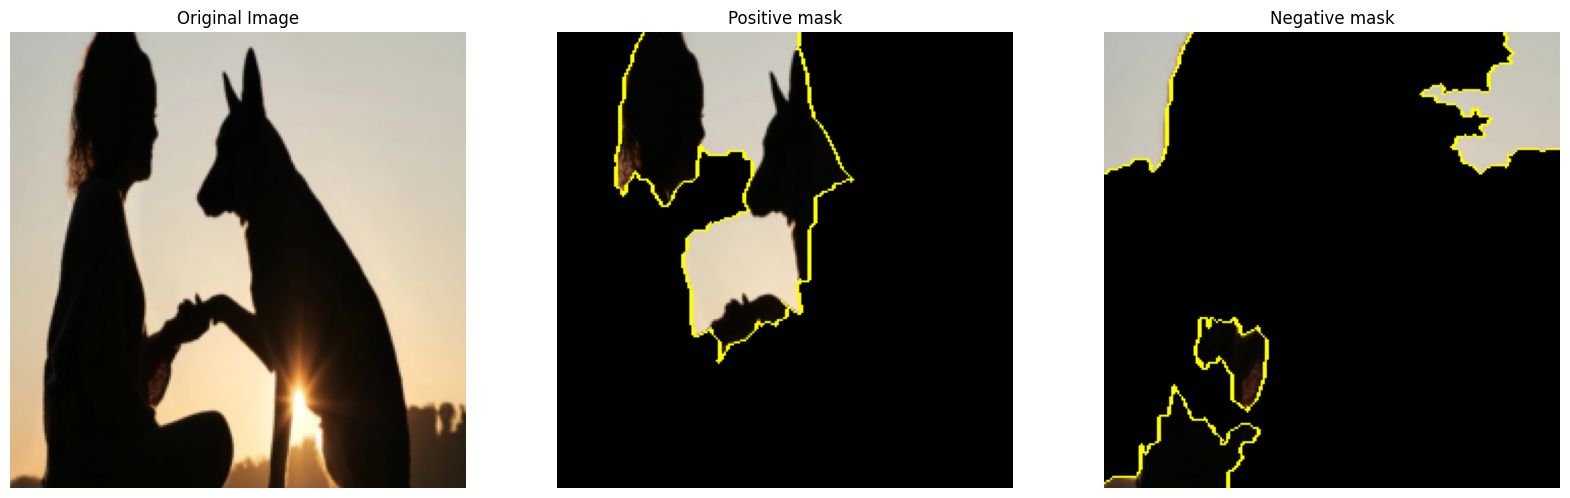

In [30]:
# Use LIME
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pil_transform(img_pil_0)), 
                                         cnn_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000)

fig, axes = plt.subplots(1,3, figsize=(20, 10))

axes[0].imshow(pil_transform(img_pil_0))
axes[0].axis('off')
axes[0].set_title("Original Image")

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, negative_only=False, 
                                            num_features=5, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[1].imshow(img_boundry)
axes[1].set_title("Positive mask")
axes[1].axis('off')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, negative_only=True, 
                                            num_features=5, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[2].imshow(img_boundry)
axes[2].set_title("Negative mask")
axes[2].axis('off')

plt.show()

((0.89324844, 171, 'Italian_greyhound'),
 (0.07475398, 172, 'whippet'),
 (0.01643678, 267, 'standard_poodle'),
 (0.0025948987, 266, 'miniature_poodle'),
 (0.0023584547, 268, 'Mexican_hairless'),
 (0.0023105363, 265, 'toy_poodle'),
 (0.0020189483, 176, 'Saluki'),
 (0.001404167, 349, 'bighorn'),
 (0.0006727636, 169, 'borzoi'),
 (0.0005164474, 158, 'toy_terrier'))

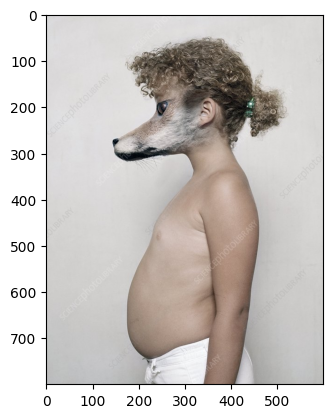

In [31]:
# Read the target image
img_pil_0 = Image.open(os.path.join("/kaggle/input/others/","fantasy.jpg")).convert('RGB')

_ = plt.imshow(img_pil_0)

# ResNet prediction
img0 = pil_to_torch(img_pil_0)

logits = resnet(img0.to(device))
probs = F.softmax(logits, dim=1).cpu()
probs5 = probs.topk(10)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

  0%|          | 0/1000 [00:00<?, ?it/s]

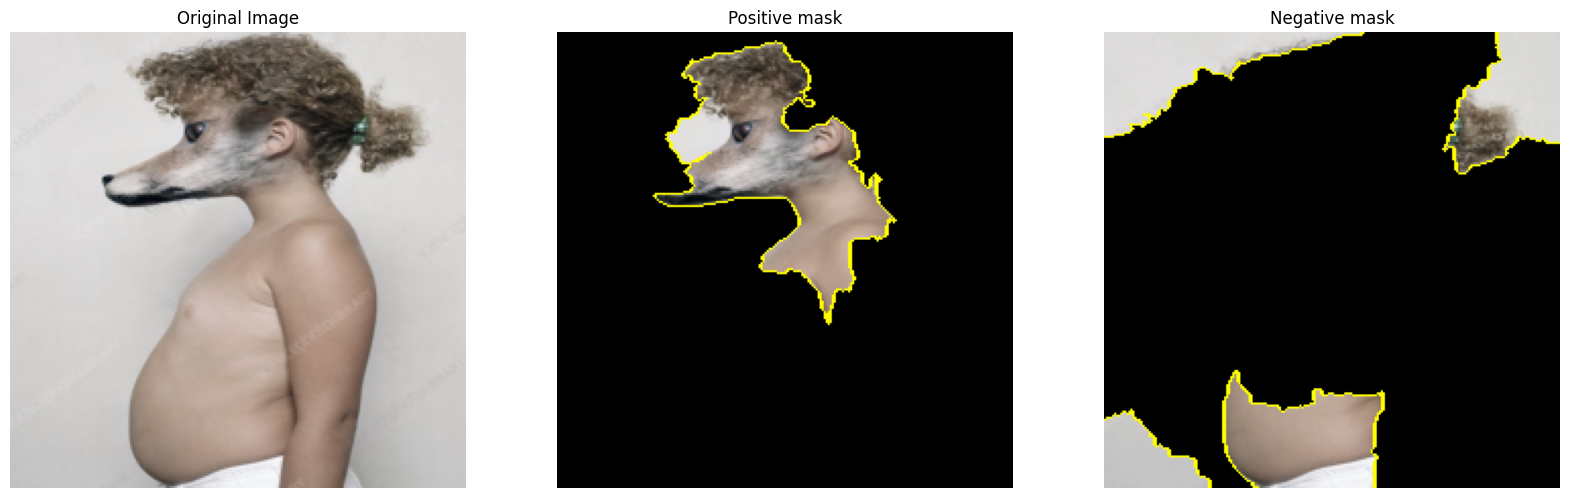

In [32]:
# Use LIME
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pil_transform(img_pil_0)), 
                                         cnn_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000)

fig, axes = plt.subplots(1,3, figsize=(20, 10))

axes[0].imshow(pil_transform(img_pil_0))
axes[0].axis('off')
axes[0].set_title("Original Image")

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, negative_only=False, 
                                            num_features=5, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[1].imshow(img_boundry)
axes[1].set_title("Positive mask")
axes[1].axis('off')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, negative_only=True, 
                                            num_features=5, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[2].imshow(img_boundry)
axes[2].set_title("Negative mask")
axes[2].axis('off')

plt.show()

((0.42330146, 208, 'Labrador_retriever'),
 (0.25241557, 207, 'golden_retriever'),
 (0.08276572, 222, 'kuvasz'),
 (0.040761586, 172, 'whippet'),
 (0.04075257, 169, 'borzoi'),
 (0.020864438, 176, 'Saluki'),
 (0.015446335, 248, 'Eskimo_dog'),
 (0.013107723, 89, 'sulphur-crested_cockatoo'),
 (0.008571106, 159, 'Rhodesian_ridgeback'),
 (0.0068637608, 212, 'English_setter'))

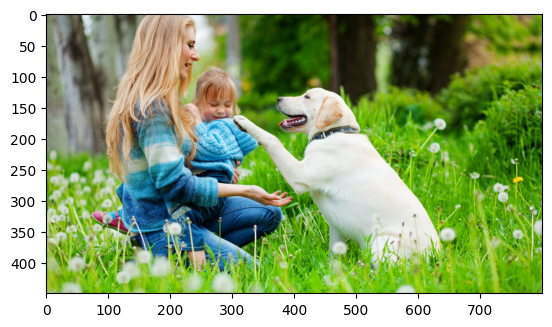

In [33]:
# Read the target image
img_pil_0 = Image.open(os.path.join("/kaggle/input/family/","family.jpg")).convert('RGB')

_ = plt.imshow(img_pil_0)

# ResNet prediction
img0 = pil_to_torch(img_pil_0)

logits = resnet(img0.to(device))
probs = F.softmax(logits, dim=1).cpu()
probs5 = probs.topk(10)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

  0%|          | 0/2000 [00:00<?, ?it/s]

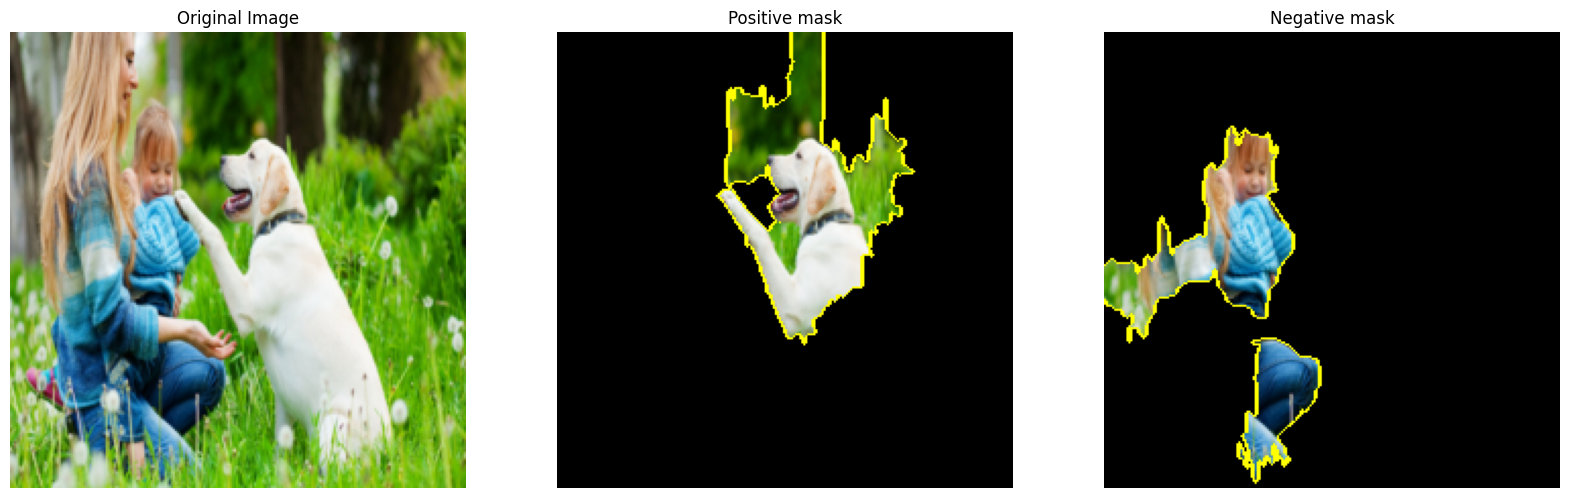

In [36]:
# Use LIME
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pil_transform(img_pil_0)), 
                                         cnn_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=2000)

fig, axes = plt.subplots(1,3, figsize=(20, 10))

axes[0].imshow(pil_transform(img_pil_0))
axes[0].axis('off')
axes[0].set_title("Original Image")

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, negative_only=False, 
                                            num_features=5, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[1].imshow(img_boundry)
axes[1].set_title("Positive mask")
axes[1].axis('off')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, negative_only=True, 
                                            num_features=5, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[2].imshow(img_boundry)
axes[2].set_title("Negative mask")
axes[2].axis('off')

plt.show()